In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import json

import torch
import torch.nn as nn
import matplotlib.pyplot as plt


In [2]:
import sys 
PROJECT_ROOT = Path.cwd().parents[0]
sys.path.append(str(PROJECT_ROOT))

DATA_DIR = Path("../data")
RESULTS_DIR = Path("../results/forecast")
MODELS_DIR = Path("../models")

SAMPLES_DIR = DATA_DIR / "era5_cropped/samples"
META_FILE = DATA_DIR / "metadata/SID_TO_NAME.csv"

RESULTS_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cpu


In [3]:
meta_df = pd.read_csv(META_FILE)

print(meta_df.head())


             SID       NAME BASIN
0                       NaN      
1  1980001S13173       PENI    SP
2  1980002S15081    DANITZA    SI
3  1980003S15137       PAUL    SP
4  1980005S11059  EGLANTINE    SI


In [4]:
test_df = pd.read_csv(
    DATA_DIR / "dataset_splits/test.csv",
    parse_dates=["time"]
)

print(test_df.head())


             sid                time  lat   lon  dlat  dlon  \
0  2006114N08090 2006-04-24 06:00:00  8.4  90.1   0.2  -0.4   
1  2006114N08090 2006-04-24 12:00:00  8.6  89.7   0.4  -0.2   
2  2006114N08090 2006-04-24 18:00:00  9.0  89.5   0.3   0.2   
3  2006114N08090 2006-04-25 00:00:00  9.3  89.7   0.3   0.2   
4  2006114N08090 2006-04-25 06:00:00  9.6  89.9   0.4  -0.3   

                           file  
0  2006114N08090_2006042406.npy  
1  2006114N08090_2006042412.npy  
2  2006114N08090_2006042418.npy  
3  2006114N08090_2006042500.npy  
4  2006114N08090_2006042506.npy  


In [5]:
last_row = test_df.sort_values("time").iloc[-1]

SID = last_row["sid"]
TIME0 = last_row["time"]
LAT0 = last_row["lat"]
LON0 = last_row["lon"]
FILE0 = last_row["file"]

storm_name = (
    meta_df[meta_df["SID"] == SID]["NAME"]
    .values[0]
    if SID in meta_df["SID"].values else "UNKNOWN"
)

print("Storm:", storm_name)
print("SID:", SID)
print("Start time:", TIME0)


Storm: DITWAH
SID: 2025331N07081
Start time: 2025-12-02 00:00:00


In [6]:
x_env = np.load(SAMPLES_DIR / FILE0).astype("float32")
x_env = torch.tensor(x_env).unsqueeze(0).to(DEVICE)


In [7]:
hist = (
    test_df[test_df["sid"] == SID]
    .sort_values("time")
    .tail(4)
)

motion_seq = hist[["dlat", "dlon"]].values
motion_seq = torch.tensor(
    motion_seq, dtype=torch.float32
).unsqueeze(0).to(DEVICE)


In [8]:
from models.cnn_mlp import CNN_MLP
from models.gru_motion import MotionGRU
from models.gru_fusion import GRUFusionModel
from models.cnn_gru import CNNGRUModel

MODEL_REGISTRY = {
    "cnn_mlp": {
        "model": CNN_MLP(),
        "weights": MODELS_DIR / "cnn_mlp/best_model.pt",
        "type": "cnn_mlp"
    },
    "gru_motion": {
        "model": MotionGRU(),
        "weights": MODELS_DIR / "gru_motion/best_gru.pt",
        "type": "gru_motion"
    },
    "gru_fusion": {
        "model": GRUFusionModel(in_channels=5),
        "weights": MODELS_DIR / "gru_fusion/best_gru_fusion.pt",
        "type": "gru_fusion"
    },
    "cnn_gru": {
        "model": CNNGRUModel(in_channels=5),
        "weights": MODELS_DIR / "cnn_gru/best_cnn_gru.pt",
        "type": "cnn_gru"
    }
}

for k in MODEL_REGISTRY:
    MODEL_REGISTRY[k]["model"].load_state_dict(
        torch.load(MODEL_REGISTRY[k]["weights"], map_location=DEVICE)
    )
    MODEL_REGISTRY[k]["model"].to(DEVICE).eval()


In [9]:
def load_era5_sequence(df, idx, T=4):
    files = []
    for k in range(T):
        files.append(df.loc[idx - (T - 1 - k), "file"])

    x_env = [
        np.load(SAMPLES_DIR / f).astype("float32")
        for f in files
    ]

    x_env = torch.tensor(np.stack(x_env))  
    return x_env.unsqueeze(0)              

In [10]:
def predict_step(model, model_type, df, idx, motion_seq):

    with torch.no_grad():

        if model_type == "cnn_mlp":
            x_env = torch.tensor(
                np.load(SAMPLES_DIR / df.loc[idx, "file"]),
                dtype=torch.float32
            ).unsqueeze(0).to(DEVICE)     

            out = model(x_env, motion_seq[:, -1])  

        elif model_type == "gru_motion":
            out = model(motion_seq)  

        elif model_type == "gru_fusion":
            x_env = torch.tensor(
                np.load(SAMPLES_DIR / df.loc[idx, "file"]),
                dtype=torch.float32
            ).unsqueeze(0).to(DEVICE)     

            out = model(x_env, motion_seq)  

        elif model_type == "cnn_gru":
            x_env_seq = load_era5_sequence(df, idx, T=4).to(DEVICE)
            out = model(x_env_seq, motion_seq)  

        else:
            raise ValueError(f"Unknown model type: {model_type}")

    return out[0].cpu().numpy()   


In [11]:
LEADS = [6, 12, 24, 48]
DT = 6  
start_idx = test_df[test_df["sid"] == SID].index[-1] 
idx = start_idx
results = []

for model_name, cfg in MODEL_REGISTRY.items():
    lat, lon = LAT0, LON0
    motion = motion_seq.clone()

    for lead in LEADS:
        steps = lead // DT
        
        for _ in range(steps):
            dlat, dlon = predict_step(
                cfg["model"],
                cfg["type"],
                test_df,
                idx,
                motion_seq
            )


            lat += dlat
            lon += dlon

            motion = torch.cat(
                [motion[:, 1:], torch.tensor([[dlat, dlon]], device=DEVICE).unsqueeze(0)],
                dim=1
            )

        results.append({
            "model": model_name,
            "lead_time": f"{lead}h",
            "lat": lat,
            "lon": lon
        })


In [12]:
forecast_df = pd.DataFrame(results)

csv_path = RESULTS_DIR / f"forecast_{SID}.csv"
forecast_df.to_csv(csv_path, index=False)

print("Saved:", csv_path)


Saved: ..\results\forecast\forecast_2025331N07081.csv


In [13]:
import pandas as pd

test_df["time"] = pd.to_datetime(test_df["time"])

last_row = test_df.iloc[-1]

init_time = last_row["time"]

print("Forecast initialized at:", init_time)


Forecast initialized at: 2025-12-02 00:00:00


In [14]:
forecast_df["lead_hr"] = (
    forecast_df["lead_time"]
    .str.replace("h", "")
    .astype(int)
)

forecast_df["init_time"] = init_time

forecast_df["forecast_time"] = (
    forecast_df["init_time"] +
    pd.to_timedelta(forecast_df["lead_hr"], unit="h")
)


In [15]:
forecast_df["init_time"] = pd.to_datetime(forecast_df["init_time"])
forecast_df["forecast_time"] = pd.to_datetime(forecast_df["forecast_time"])


In [16]:
forecast_df.dtypes


model                    object
lead_time                object
lat                     float64
lon                     float64
lead_hr                   int32
init_time        datetime64[ns]
forecast_time    datetime64[ns]
dtype: object

In [17]:
forecast_df["forecast_time_str"] = (
    forecast_df["forecast_time"]
    .dt.strftime("%Y-%m-%d %H:%M UTC")
)


In [18]:
forecast_df[
    ["model", "lead_time", "init_time", "forecast_time", "lat", "lon"]
].head()


,model,lead_time,init_time,forecast_time,lat,lon
0,cnn_mlp,6h,2025-12-02,2025-12-02 06:00:00,12.484345,80.889570
1,cnn_mlp,12h,2025-12-02,2025-12-02 12:00:00,12.453034,81.468710
2,cnn_mlp,24h,2025-12-02,2025-12-03 00:00:00,12.390414,82.626991
3,cnn_mlp,48h,2025-12-02,2025-12-04 00:00:00,12.265172,84.943552
4,gru_motion,6h,2025-12-02,2025-12-02 06:00:00,11.572046,81.377006


In [19]:
forecast_df.drop(columns=["lead_hr"], inplace=True)

forecast_df.to_csv(
    "D:/cyclone_forecasting/results/forecast/forecast_2025331N07081.csv",
    index=False
)

print("Forecast CSV updated with timestamps")


Forecast CSV updated with timestamps


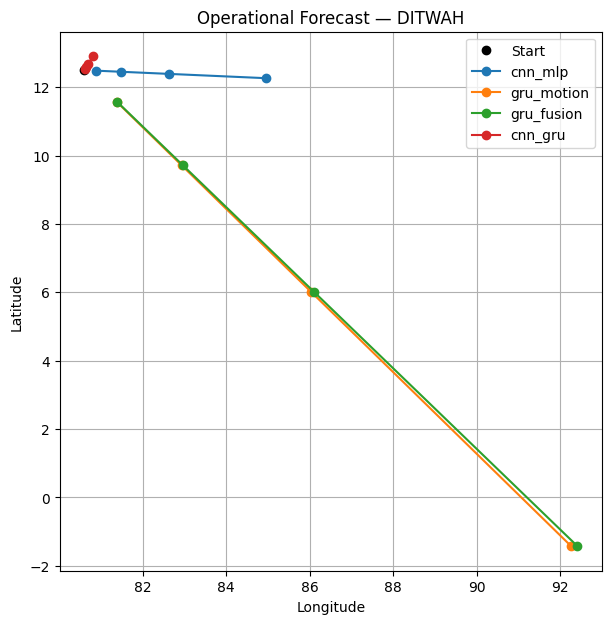

Saved: ..\results\forecast\forecast_2025331N07081.png


In [20]:
plt.figure(figsize=(7,7))
plt.plot(LON0, LAT0, "ko", label="Start")

for model in forecast_df["model"].unique():
    d = forecast_df[forecast_df["model"] == model]
    plt.plot(d["lon"], d["lat"], "-o", label=model)

plt.title(f"Operational Forecast — {storm_name}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)

plot_path = RESULTS_DIR / f"forecast_{SID}.png"
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", plot_path)


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
TEST_CSV = "D:/cyclone_forecasting/data/dataset_splits/test.csv"
FORECAST_CSV = "D:/cyclone_forecasting/results/forecast/forecast_2025331N07081.csv"
SAVE_DIR = "D:/cyclone_forecasting/results/figures/forecast"

test_df = pd.read_csv(TEST_CSV)
forecast_df = pd.read_csv(FORECAST_CSV)

SAVE_DIR = Path(SAVE_DIR)
SAVE_DIR.mkdir(parents=True, exist_ok=True)


In [22]:
MODEL_COLORS = {
    "cnn_mlp": "blue",
    "cnn_gru": "red",
    "gru_motion": "green",
    "gru_fusion": "purple"
}


In [23]:
history_df = test_df[test_df["sid"] == SID].sort_values("time")

assert len(history_df) > 0, "Observed track is empty!"

true_lon = history_df["lon"].values
true_lat = history_df["lat"].values


In [24]:
forecast_df = pd.read_csv(
    "D:/cyclone_forecasting/results/forecast/forecast_2025331N07081.csv"
)

assert len(forecast_df) > 0, "Forecast dataframe is empty!"


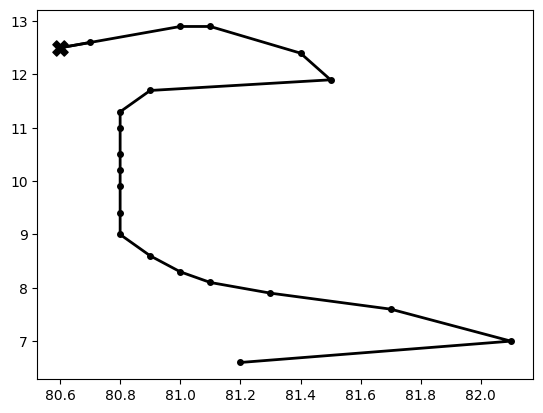

In [25]:
plt.plot(
    true_lon,
    true_lat,
    "-ok",
    linewidth=2,
    markersize=4,
    label="Observed Track"
)

plt.scatter(
    true_lon[-1],
    true_lat[-1],
    c="black",
    s=120,
    marker="X",
    zorder=5,
    label="Forecast Start"
)

plt.plot(
    [true_lon[-2], true_lon[-1]],
    [true_lat[-2], true_lat[-1]],
    color="black",
    linewidth=2,
    linestyle="-"
)



In [26]:
forecast_tracks = {}

for entry in results:
    m_name = entry["model"]
    if m_name not in forecast_tracks:
        forecast_tracks[m_name] = {"lat": [], "lon": []}
    
    forecast_tracks[m_name]["lat"].append(entry["lat"])
    forecast_tracks[m_name]["lon"].append(entry["lon"])

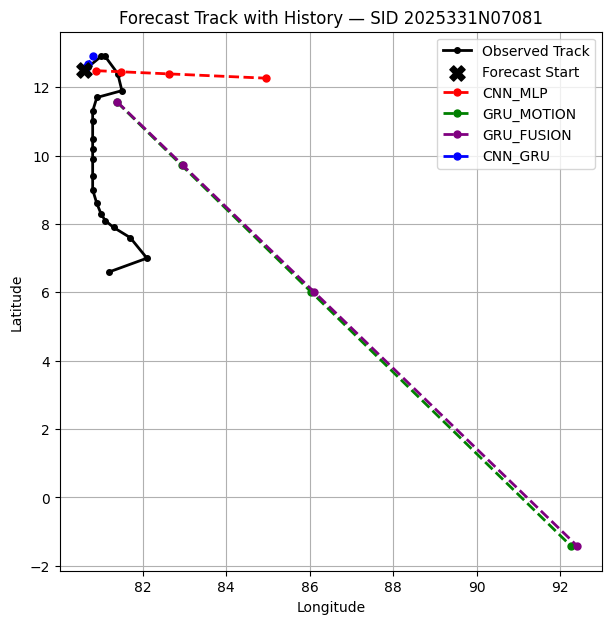

Saved: D:\cyclone_forecasting\results\figures\forecast\forecast_with_history_2025331N07081.png


In [27]:
plt.figure(figsize=(7, 7))

plt.plot(
    true_lon,
    true_lat,
    "-ok",
    linewidth=2,
    markersize=4,
    label="Observed Track"
)

plt.scatter(
    true_lon[-1],
    true_lat[-1],
    c="black",
    s=120,
    marker="X",
    zorder=5,
    label="Forecast Start"
)

colors = {
    "cnn_mlp": "red",
    "cnn_gru": "blue",
    "gru_motion": "green",
    "gru_fusion": "purple"
}

for model_name, track in forecast_tracks.items():
    lon_f = track["lon"]
    lat_f = track["lat"]

    if len(lon_f) == 0:
        continue  

    plt.plot(
        lon_f,
        lat_f,
        "--o",
        color=colors[model_name],
        linewidth=2,
        markersize=5,
        label=model_name.upper()
    )

plt.title(f"Forecast Track with History — SID {SID}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

plt.legend(loc="best")

save_path = (
    SAVE_DIR / f"forecast_with_history_{SID}.png"
)

plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", save_path)


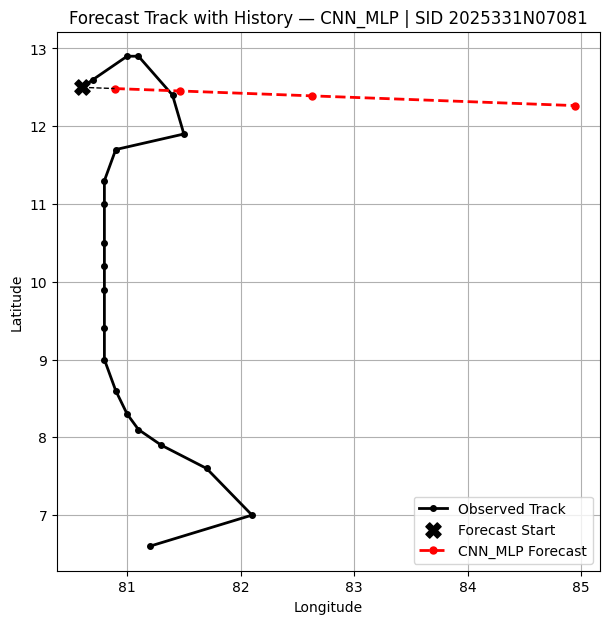

Saved: D:\cyclone_forecasting\results\figures\forecast\2025331N07081_cnn_mlp_forecast_with_history.png


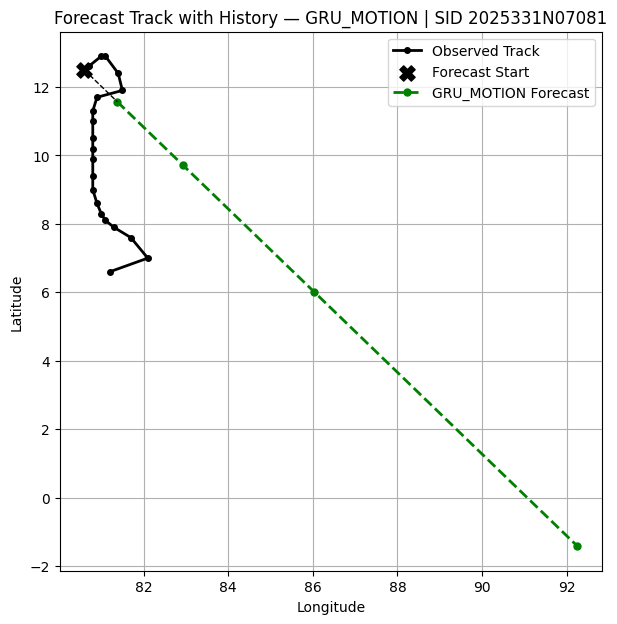

Saved: D:\cyclone_forecasting\results\figures\forecast\2025331N07081_gru_motion_forecast_with_history.png


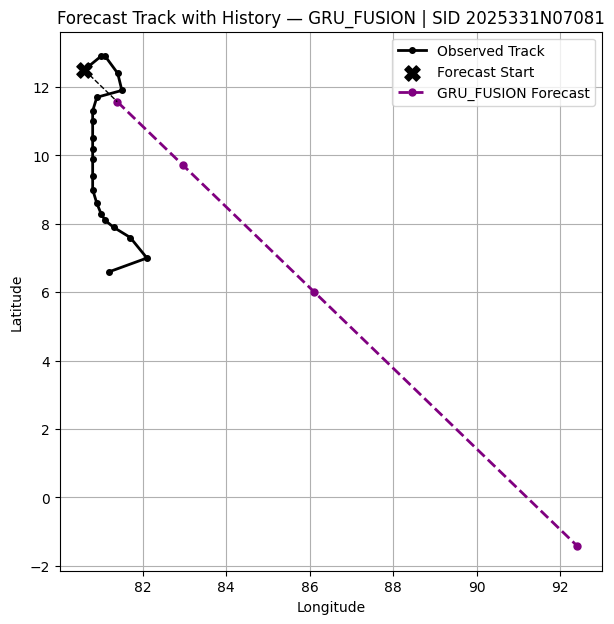

Saved: D:\cyclone_forecasting\results\figures\forecast\2025331N07081_gru_fusion_forecast_with_history.png


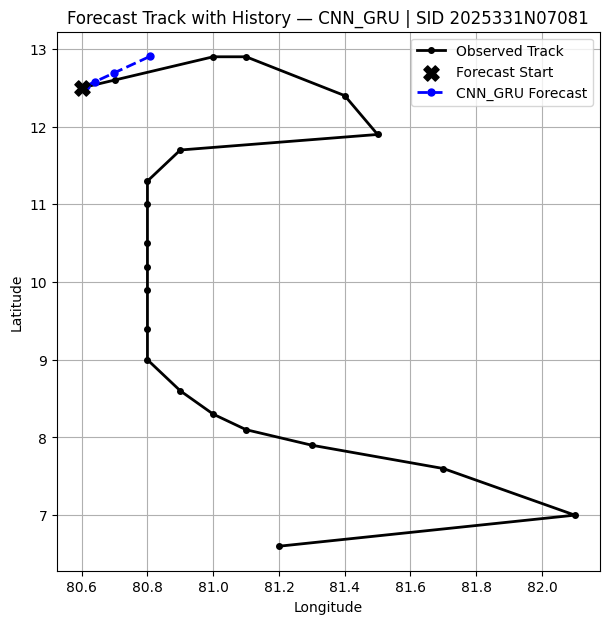

Saved: D:\cyclone_forecasting\results\figures\forecast\2025331N07081_cnn_gru_forecast_with_history.png


In [28]:
import matplotlib.pyplot as plt

model_colors = {
    "cnn_mlp": "red",
    "cnn_gru": "blue",
    "gru_motion": "green",
    "gru_fusion": "purple"
}

for model_name, track in forecast_tracks.items():

    lon_f = track["lon"]
    lat_f = track["lat"]

    if len(lon_f) == 0:
        print(f"Skipping {model_name} (no forecast)")
        continue

    plt.figure(figsize=(7, 7))

    plt.plot(
        true_lon,
        true_lat,
        "-ok",
        linewidth=2,
        markersize=4,
        label="Observed Track"
    )

    plt.scatter(
        true_lon[-1],
        true_lat[-1],
        c="black",
        s=120,
        marker="X",
        zorder=5,
        label="Forecast Start"
    )

    plt.plot(
        lon_f,
        lat_f,
        "--o",
        color=model_colors[model_name],
        linewidth=2,
        markersize=5,
        label=f"{model_name.upper()} Forecast"
    )
    plt.plot(
    [true_lon[-1], lon_f[0]],
    [true_lat[-1], lat_f[0]],
    "k--",
    linewidth=1
)
    plt.title(f"Forecast Track with History — {model_name.upper()} | SID {SID}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.legend(loc="best")

    save_path = (
        SAVE_DIR / f"{SID}_{model_name}_forecast_with_history.png"
    )

    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

    print("Saved:", save_path)


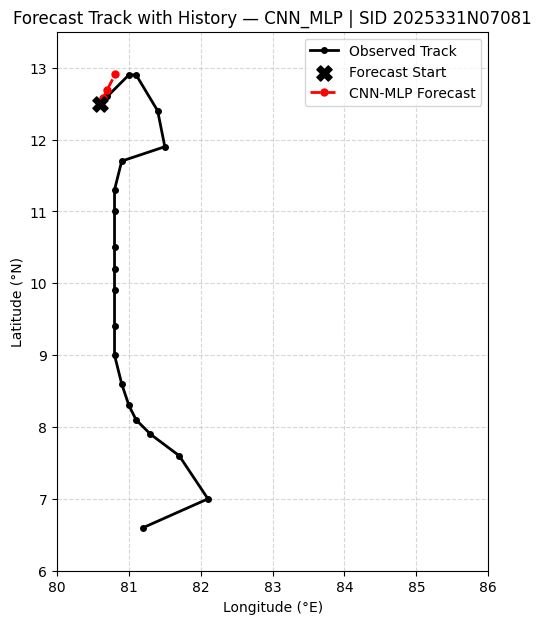

Saved: D:\cyclone_forecasting\results\figures\forecast\2025331N07081_cnn_gru_CNN_MLP_forecast.png


In [29]:

plt.figure(figsize=(7, 7))

plt.plot(
    true_lon,
    true_lat,
    "-ok",
    linewidth=2,
    markersize=4,
    label="Observed Track"
)

plt.scatter(
    true_lon[-1],
    true_lat[-1],
    c="black",
    s=120,
    marker="X",
    zorder=5,
    label="Forecast Start"
)

plt.plot(
    lon_f,
    lat_f,
    "--or",
    linewidth=2,
    markersize=5,
    label="CNN-MLP Forecast"
)

all_lon = list(true_lon) + list(lon_f)
all_lat = list(true_lat) + list(lat_f)

lon_pad = 0.5
lat_pad = 0.5

plt.xlim(80,86)
plt.ylim(6,13.5)

plt.gca().set_aspect("equal", adjustable="box")

plt.xlabel("Longitude (°E)")
plt.ylabel("Latitude (°N)")
plt.title(f"Forecast Track with History — CNN_MLP | SID {SID}")

plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)


save_path = (
        SAVE_DIR / f"{SID}_{model_name}_CNN_MLP_forecast.png"
    )

plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()



print("Saved:", save_path)
